# 2. Example: ETKF Assimilation on Lorenz96 using Lorenz96 model

In this notebook, we'll follow the same steps as in the first example notebook but this time we'll use an Ensemble transform Kalman filter. You'll notice that almost all the steps are the same, we just have to tweak how we set up the DACycler. In DABench, all DA Cycler experiments follow the same 4 A-B-C-D steps.

In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt

# A. Create Nature Run

In [2]:
nature_run = dab.data.Lorenz96(system_dim=6, delta_t=0.01, store_as_jax=True)
nature_run.generate(n_steps=5000)

# B. Generate observations

In [3]:
# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nature_run, # Data generator object
    time_indices = np.arange(0, 5000, 5), # Observation every 5th timestep
    random_location_count = 3, # We'll select 3 elements of l96.system_dim for random sampling
    error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
    error_sd = 1.0, # Standard deviation for observation error, Gaussian/Normal distribution
    random_seed=91, # We can specify a random seed. Default is 99
    stationary_observers=True,
    store_as_jax=True
)

# Creating observations using the observer
obs_vec_l96 = obs_l96.observe()

# C. Define Model


In [4]:
# We'll use Lorenz 96 as our forecast model for the DA Cycler
# If we gave it the exact same starting conditions as the nature_run, it would
# forecast perfectly. But instead it will be given observations with error.

class L96Model(dab.model.Model):                                                                       
    """Defines model wrapper for Lorenz96 to test forecasting."""
    
    def forecast(self, state_vec):
        """This method needs to be user-defined for the DA Cycler to use
        Args:
            state_vec (dabench.vector.StateVector): Current model state.
            
        Returns:
            StateVector containing the forecast for the next timestep.
            
        """
        # Step forward one timestep
        self.model_obj.generate(x0=state_vec.values, n_steps=2)
        
        # Output 
        new_vals = self.model_obj.values[-1]

        new_vec = dab.vector.StateVector(values=new_vals, store_as_jax=True)

        return new_vec

In [5]:
forecast_model = L96Model(model_obj=dab.data.Lorenz96(system_dim=6, delta_t=0.01, store_as_jax=True))

#### Brief aside: What if we didn't use Data Assimilation?

Instead, let's to reproduce the data using our L96 model from the *same ensemble input state* we'll use for the DA cycler

In [6]:
etkf_x0_vals = nature_run.values[1000] + np.random.normal(size=(10, 6))*3

In [7]:
out_vals = []
for i in range(10):
    toy_model = dab.data.Lorenz96(system_dim=6, delta_t=0.01, store_as_jax=True)
    toy_model.generate(x0 = etkf_x0_vals[i], n_steps=5000)
    out_vals.append(toy_model.values)

In [8]:
out_array = np.stack(out_vals)

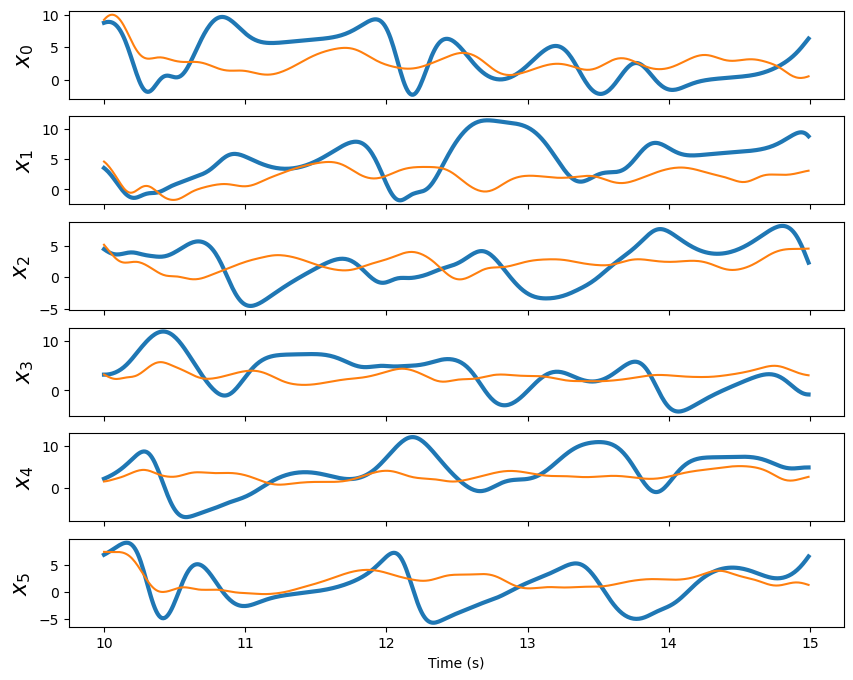

In [9]:
# Pretty bad reproduction
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nature_run.times[1000:1500], nature_run.values[1000:1500,j], lw = 3, label = 'True')
    ax.plot(nature_run.times[1000:1500], np.mean(out_array, axis=0)[0:500,j])
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
ax.set_xlabel('Time (s)')
plt.show()

## D. Define and Run DA Cycler

In [10]:
dc = dab.dacycler.ETKF(system_dim=nature_run.system_dim, # 6
                   delta_t=nature_run.delta_t,
                   model_obj=forecast_model, # Forecast model we created above
                   ensemble_dim=10 # Ensemble dim for Ensemble Kalman Filter
                  )


In [11]:
cur_tstep = 1000

# ETKF input state is an ensemble with error
etkf_x0 = dab.vector.StateVector(
    values=nature_run.values[cur_tstep] + np.random.normal(size=(10, 6), scale=3),
    store_as_jax=True)

# Run cycler for 3000 timesteps
out_statevec = dc.cycle(
    input_state = etkf_x0,
    start_time = nature_run.times[cur_tstep],
    obs_vector = obs_vec_l96,
    obs_error_sd = 1.5,
    analysis_window=0.1, 
    timesteps=3000)

Now let's plot our results

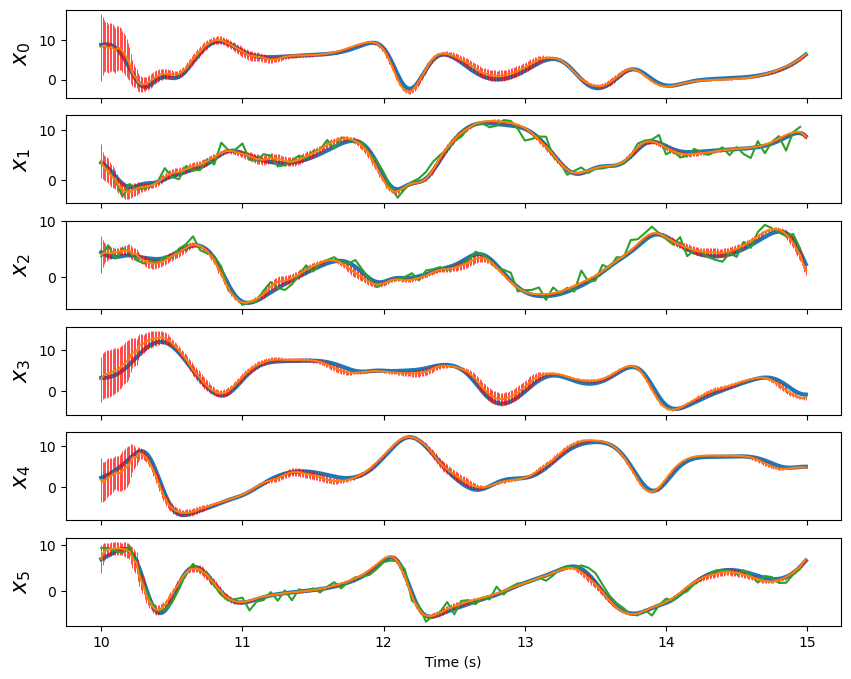

In [12]:
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(out_statevec.times[:500], nature_run.values[1000:1500,j], lw = 3, label = 'True')
    ax.errorbar(out_statevec.times[:500], np.mean(out_statevec.values, axis=1)[:500,j],
                yerr=np.ptp(out_statevec.values, axis=1)[:500,j], elinewidth=0.5, ecolor='red')
    ax.plot(obs_vec_l96.times[200:300], obs_vec_l96.values[200:300, np.where(j == obs_vec_l96.location_indices[0])[0]])
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
ax.set_xlabel('Time (s)')
plt.show()

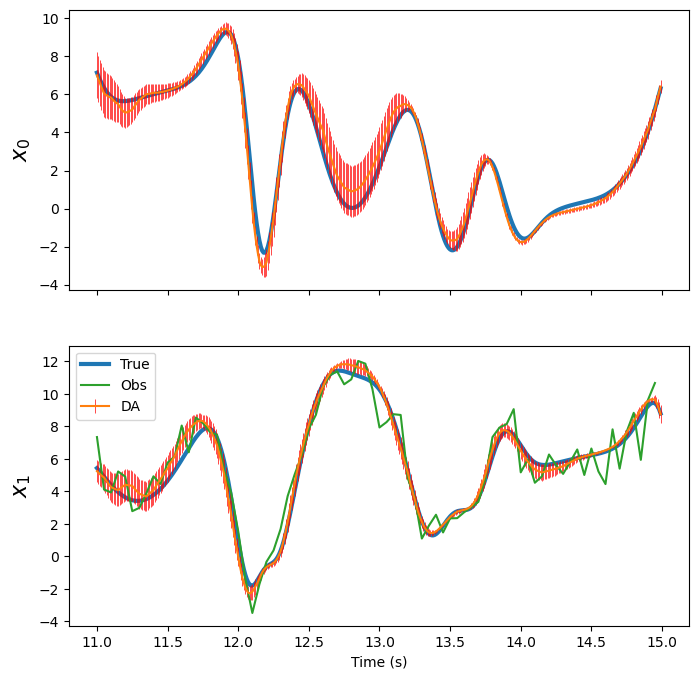

In [13]:
# Zoom in a bit to see the error more clearly
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (8, 8))
for j, ax in enumerate(axes):
    ax.plot(out_statevec.times[100:500], nature_run.values[1100:1500,j], lw = 3, label = 'True')
    ax.errorbar(out_statevec.times[100:500], np.mean(out_statevec.values, axis=1)[100:500,j],
                yerr=np.ptp(out_statevec.values, axis=1)[100:500,j], elinewidth=0.5, ecolor='red', label='DA')
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
    ax.plot(obs_vec_l96.times[220:300], obs_vec_l96.values[220:300, np.where(j == obs_vec_l96.location_indices[0])[0]], label='Obs')
ax.set_xlabel('Time (s)')
axes[1].legend()
plt.show()